# Fit training trials from exp 1 and simulate test trials 

In [96]:
import pickle
import random
import pandas as pd
import numpy as np
from itertools import product
from typing import Sequence, Dict, Any, Optional, Tuple, List

from construal_shifting.task_modeling.simulated_participant_model import SimulatedParticipantData
from construal_shifting.task_modeling.base_dataclasses import ParticipantDataBase
from construal_shifting.task_modeling.model_fitter import ModelFitter

from data_analysis import ExperimentDataLoader, ParticipantData, GridNavigationTrialData
from msdm.core.utils.funcutils import cached_property, method_cache

In [97]:
exp_data = ExperimentDataLoader(
    trialdata_file="rawtrialdata-anon.csv"
)
summary_df = pd.read_json('./data/summary_df.json')
all_participant_data = [p for p in exp_data.completed_participant_data() if p.sessionId in summary_df.sessionId.values]

In [98]:
class OnlyTrainingParticipantData(ParticipantData):
    # this is a wrapper class that only returns training trials as main trials
    # since ModelFitter hooks into `main_trials` 
    def __init__(self, full_participant_data: ParticipantData):
        self.full_participant_data = full_participant_data
    
    def main_trials(self) -> List[GridNavigationTrialData]:
        trials = self.training_trials()
        assert len(trials) == 12, f"{self.sessionId}: Expected 12 training trials, got {len(trials)}"
        return trials
    
    def __getattr__(self, attr):
        assert attr != "main_trials", "main_trials is a reserved attribute"
        return getattr(self.full_participant_data, attr)

In [99]:
only_training_pdata = [OnlyTrainingParticipantData(pdata) for pdata in all_participant_data]

## Increased bound 

In [5]:
fixed_params=dict(
    construal_cost_weight=.0,
    construal_set_stickiness=.0,
    construal_inverse_temp=1.0,
    action_inverse_temp=float('inf'),
    action_random_choice=.1,
)
param_bounds = dict(
    construal_set_stickiness=(0., 15.),
    construal_cost_weight=(0., 10.),
    construal_inverse_temp=(0., 10),
    action_inverse_temp=(1e-2, 10),
    action_random_choice=(.01, 1.), #we need to lower bound to avoid numerical issues
)
rng = random.Random(51131)
fitter = ModelFitter(only_training_pdata)
params_to_fit=["construal_cost_weight", "construal_set_stickiness", "action_random_choice"]
fit_res = fitter.fit_params(
    fixed_params={p: v for p, v in fixed_params.items() if p not in params_to_fit},
    params_to_fit=params_to_fit,
    param_bounds=param_bounds,
    maxfun=200,
    runs=5,
    seed=rng.randint(0, int(1e7))
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [10]:
fit_model_params = min(fit_res, key=lambda x: x.neg_log_like).model_params
fit_model_params

{'construal_inverse_temp': 1.0,
 'action_inverse_temp': inf,
 'action_random_choice': 0.1081411774795119,
 'construal_cost_weight': 1.1392859500747181,
 'construal_set_stickiness': 13.916151334369541}

In [8]:
pickle.dump(fit_model_params, open('./data/model_fits-training_only.pkl', 'wb'))

## Original bound 

In [11]:
fixed_params=dict(
    construal_cost_weight=.0,
    construal_set_stickiness=.0,
    construal_inverse_temp=1.0,
    action_inverse_temp=float('inf'),
    action_random_choice=.1,
)
param_bounds = dict(
    construal_set_stickiness=(0., 10.),
    construal_cost_weight=(0., 10.),
    construal_inverse_temp=(0., 10),
    action_inverse_temp=(1e-2, 10),
    action_random_choice=(.01, 1.), #we need to lower bound to avoid numerical issues
)
rng = random.Random(51131)
fitter = ModelFitter(only_training_pdata)
params_to_fit=["construal_cost_weight", "construal_set_stickiness", "action_random_choice"]
fit_res = fitter.fit_params(
    fixed_params={p: v for p, v in fixed_params.items() if p not in params_to_fit},
    params_to_fit=params_to_fit,
    param_bounds=param_bounds,
    maxfun=200,
    runs=5,
    seed=rng.randint(0, int(1e7))
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
fit_model_params = min(fit_res, key=lambda x: x.neg_log_like).model_params
fit_model_params

{'construal_inverse_temp': 1.0,
 'action_inverse_temp': inf,
 'action_random_choice': 0.10812124369192674,
 'construal_cost_weight': 1.1739122783618223,
 'construal_set_stickiness': 10.0}

In [15]:
pickle.dump(fit_model_params, open('./data/model_fits-training_only-original_bound.pkl', 'wb'))

# Simulate on test trials

In [13]:
import pickle
import random
from typing import Sequence, Dict, Any, Optional, Tuple, List
import pandas as pd
from tqdm.notebook import tqdm

from construal_shifting.task_modeling.simulated_participant_model import SimulatedParticipantData
from construal_shifting.task_modeling.base_dataclasses import ParticipantDataBase

from data_analysis import ExperimentDataLoader, ParticipantData, GridNavigationTrialData, calculate_critical_notch_locs

fit_model_params = pickle.load(open('./data/model_fits-training_only-original_bound.pkl', 'rb'))

exp_data = ExperimentDataLoader(
    trialdata_file="rawtrialdata-anon.csv"
)
summary_df = pd.read_json('./data/summary_df.json')
all_participant_data = [p for p in exp_data.completed_participant_data() if p.sessionId in summary_df.sessionId.values]

In [14]:
class OnlyTestParticipantData(ParticipantData):
    # this is a wrapper class that only returns TEST trials as main trials
    # since ModelFitter hooks into `main_trials` 
    def __init__(self, full_participant_data: ParticipantData):
        self.full_participant_data = full_participant_data
    
    def main_trials(self) -> List[GridNavigationTrialData]:
        trials = self.test_trials()
        assert len(trials) == 8, f"{self.sessionId}: Expected 8 training trials, got {len(trials)}"
        return trials
    
    def __getattr__(self, attr):
        assert attr != "main_trials", "main_trials is a reserved attribute"
        return getattr(self.full_participant_data, attr)

In [15]:
only_test_pdata = [OnlyTestParticipantData(pdata) for pdata in all_participant_data]

In [16]:
def generate_simulated_participants(
    all_participant_data : Sequence[ParticipantDataBase],
    construal_cost_weight : float,
    construal_inverse_temp : float,
    action_inverse_temp : float,
    action_random_choice : float,
    construal_set_stickiness : float,
    rng : random.Random
) -> Sequence[SimulatedParticipantData]:
    simulated_participants = []
    for participant_data in tqdm(all_participant_data):
        simulated_participant = SimulatedParticipantData.from_real_participant(
            participant_data=participant_data,
            construal_cost_weight=construal_cost_weight,
            construal_inverse_temp=construal_inverse_temp,
            action_inverse_temp=action_inverse_temp,
            action_random_choice=action_random_choice,
            construal_set_stickiness=construal_set_stickiness,
            seed=rng.randint(0, 2**32),
        )
        simulated_participants.append(simulated_participant)
    return simulated_participants

print(fit_model_params)
sim_participants = generate_simulated_participants(
    all_participant_data=all_participant_data,
    rng=random.Random(1391),
    # **{
    #     'construal_inverse_temp': 1.0,
    #     'action_inverse_temp': float('inf'),
    #     'action_random_choice': 0.1081411774795119,
    #     'construal_cost_weight': 1.69,
    #     'construal_set_stickiness': 5.33
    # }
    **fit_model_params
)

{'construal_inverse_temp': 1.0, 'action_inverse_temp': inf, 'action_random_choice': 0.10812124369192674, 'construal_cost_weight': 1.1739122783618223, 'construal_set_stickiness': 10.0}


  0%|          | 0/377 [00:00<?, ?it/s]

In [17]:
sim_stats = []
for sim in sim_participants:
    test_trials = sim.main_trials()[-8:]
    for t in test_trials:
        cog_cost = {'coarse': t.coarse_set_cognitive_cost, 'fine': t.fine_set_cognitive_cost}[t.current_construal_set]
        critical_notch_locs = calculate_critical_notch_locs(t.invtransformed_GridWorld_params['tile_array'])
        visited_critical_notch = len(set(t.invtransformed_state_traj) & set(critical_notch_locs)) > 0
        sim_stats.append({
            'sessionId': sim.sessionId,
            'trial_index': t.trial_index,
            'cog_cost': cog_cost,
            'visited_critical_notch': visited_critical_notch,
            'condition_name': sim.condition_name
        })
sim_stats = pd.DataFrame(sim_stats)

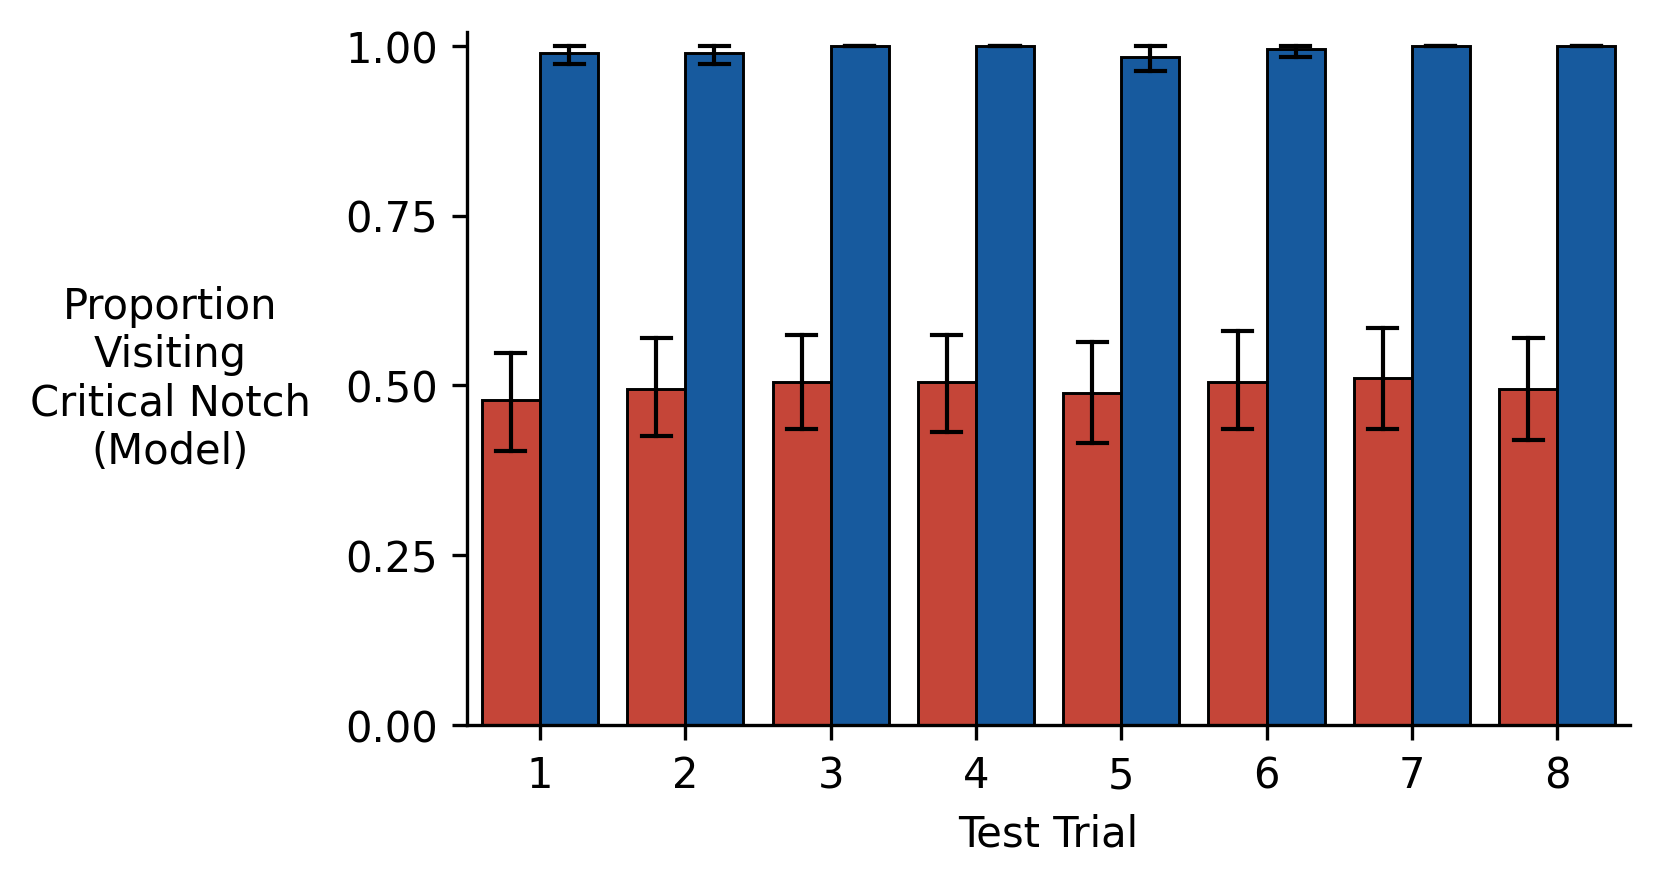

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
# sim_stats.groupby(['condition_name', 'trial_index'])[['visited_critical_notch']].mean()

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
g = sns.barplot(
    ax=ax,
    data=sim_stats,
    x='trial_index',
    y='visited_critical_notch',
    hue='condition_name',
    hue_order=['cccccccccccc', 'ffffffffffff'],
    palette=["#DC3220", "#005AB5"],
    errwidth=1.,
    edgecolor='k',
    linewidth=.7,
    capsize=.2,
    errcolor='k',
    errorbar=('ci', 95)
)
g.set_ylim(0, 1.02)
g.set_yticks([0, .25, .5, .75, 1.0])
g.get_legend().remove()
ax.set_ylabel(
    "Proportion\nVisiting\nCritical Notch\n(Model)",
    rotation="horizontal",
    labelpad=42,
    va='center'
)
ax.set_xlabel("Test Trial")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set_xticklabels(["1", "2", "3", "4", "5", '6', '7', '8'])

[Text(0, 0, 'Visited\nCritical Notch\n(Short Path)'),
 Text(1, 0, 'Did Not Visit\nCritical Notch\n(Long Path)')]

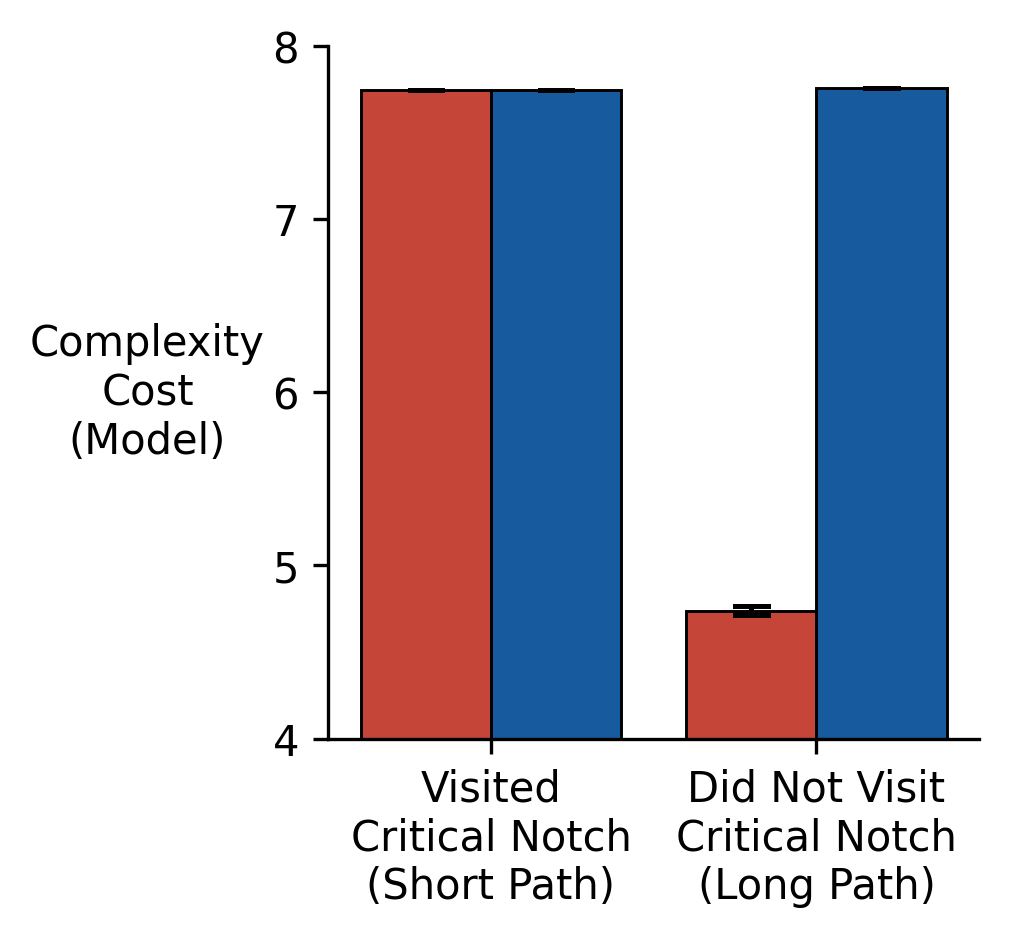

In [19]:
sim_stats.groupby(['condition_name', 'visited_critical_notch'])[['cog_cost']].mean()

fig, ax = plt.subplots(1, 1, figsize=(2.8, 3), dpi=300)
sns.barplot(
    data=sim_stats,
    y='cog_cost',
    x='visited_critical_notch',
    hue='condition_name',
    palette={'ffffffffffff': '#005AB5', 'cccccccccccc': "#DC3220"},
    errorbar=('ci', 95),
    errwidth=1.2,
    edgecolor='k',
    linewidth=.7,
    capsize=.1,
    errcolor='k',
    hue_order=['cccccccccccc', 'ffffffffffff', ],
    order=[True, False],
    ax=ax
)
ax.set_ylim(4, 8)
_ = ax.set_yticks([4, 5, 6, 7, 8])
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(
    "Complexity\nCost\n(Model)",
    rotation="horizontal",
    labelpad=30,
    va='center'
)
ax.set_xlabel(None)
ax.set_xticklabels([
    {'True': 'Visited\nCritical Notch\n(Short Path)', 'False': 'Did Not Visit\nCritical Notch\n(Long Path)'}[t.get_text()]
    for t in ax.get_xticklabels()
])
# # plt.savefig('./figures/exp1_init_rt_plot_2.pdf', bbox_inches = "tight")